## Import Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l1_l2

## Setup Dataset

In [2]:
import pathlib

train_dir = pathlib.Path("/Users/leonardo/Documents/Projects/cryptovision/data/processed/train")
test_dir = pathlib.Path("/Users/leonardo/Documents/Projects/cryptovision/data/processed/test")
valid_dir = pathlib.Path("/Users/leonardo/Documents/Projects/cryptovision/data/processed/valid")


In [3]:
batch_size = 64
img_height = 224
img_width = 224

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  #validation_split=0.40,
  #subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode="categorical",
)

valid_ds = tf.keras.utils.image_dataset_from_directory(
  valid_dir,
  #validation_split=0.40,
  #subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode="categorical",
  )

test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode="categorical",
)

Found 5789 files belonging to 57 classes.
Found 1448 files belonging to 57 classes.
Found 1810 files belonging to 57 classes.


2024-08-13 06:24:00.978379: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-08-13 06:24:00.978403: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2024-08-13 06:24:00.978412: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2024-08-13 06:24:00.978432: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-08-13 06:24:00.978446: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### Class Names

In [5]:
class_names = train_ds.class_names

### Datasets Autotune

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Image preprocessing layers

In [7]:
# Model preprocess
preprocess_input = tf.keras.applications.efficientnet_v2.preprocess_input

# Data Augmentation Function
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.2),  # Randomly zoom in on the image
  tf.keras.layers.RandomTranslation(0.1, 0.1),  # Randomly translate the image in horizontal and vertical directions
  tf.keras.layers.RandomContrast(0.2),  # Adjust the contrast of the image
  tf.keras.layers.RandomBrightness(0.2),  # Adjust the brightness of the image
  tf.keras.layers.RandomCrop(224, 224)  # Randomly crop the image to the target size
])

## Model Configuration

### Model Architecture

In [8]:
# Base model for EfficientNetV2
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(
    include_top=False, 
    weights='imagenet', 
    pooling='avg',
    input_shape=(224, 224, 3)
)

#Nontrainable layers
base_model.trainable = False

# Inputs
inputs = tf.keras.Input(shape=(224, 224, 3))

# Layers Configuration
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=True)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(
    1024,
    activation="relu",
    kernel_regularizer=l1_l2(l1=0.001, l2=0.001),
)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.2)(x)

# Output layers
output_species = tf.keras.layers.Dense(len(class_names), activation="softmax")(x)

# Final Model Setup
model = tf.keras.models.Model(inputs=inputs, outputs=[output_species])

# Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=['accuracy','AUC', 'Precision', 'Recall'],
)

### Model with Attention Architecture

In [9]:
import tensorflow as tf
from tensorflow.keras.layers import Layer

class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.dense = tf.keras.layers.Dense(input_shape[-1], activation='sigmoid')
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        # Global Average Pooling
        avg_pool = tf.keras.layers.GlobalAveragePooling2D()(inputs)
        # Dense layer to learn attention weights
        attention = self.dense(avg_pool)
        # Reshape attention weights to match the input dimensions
        attention = tf.keras.layers.Reshape((1, 1, inputs.shape[-1]))(attention)
        # Multiply the attention weights with the original inputs
        output = tf.keras.layers.Multiply()([inputs, attention])
        return output


# Base model for EfficientNetV2
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(
    include_top=False, 
    weights='imagenet', 
    pooling=None,  # We will not pool yet, as we'll do it after applying attention
    input_shape=(224, 224, 3)
)

# Non-trainable layers
base_model.trainable = False

# Inputs
inputs = tf.keras.Input(shape=(224, 224, 3))

# Layers Configuration
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)

# Apply the custom attention layer here
x = AttentionLayer()(x)

# Apply Global Average Pooling after attention
x = tf.keras.layers.GlobalAveragePooling2D()(x)

x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(
    1024,
    activation="relu",
    kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.001, l2=0.001),
)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.2)(x)

# Output layers
output_species = tf.keras.layers.Dense(len(class_names), activation="softmax")(x)

# Final Model Setup
model_attention = tf.keras.models.Model(inputs=inputs, outputs=[output_species])

# Compile
model_attention.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=['accuracy','AUC', 'Precision', 'Recall'],
)

### Summary

In [10]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 1280)           │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     1,311,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 57)             │        58,425 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,293,577 (27.82 MB)

 Trainable params: 1,372,217 (5.23 MB)

 Non-trainable params: 5,921,360 (22.59 MB)

In [11]:
model_attention.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer                 │ (None, 7, 7, 1280)     │     1,639,680 │
│ (AttentionLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1024)           │     1,311,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 57)             │        58,425 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,933,257 (34.08 MB)

 Trainable params: 3,011,897 (11.49 MB)

 Non-trainable params: 5,921,360 (22.59 MB)

### Model Training

In [12]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

epochs=10

# Define callbacks
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2,
    patience=3,
    min_lr=1e-6,
)
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True,
)
    
history = model.fit(
  train_ds,
  validation_data=valid_ds,
  epochs=epochs,
  callbacks=[
      early_stop,
      reduce_lr,
  ]
)

Epoch 1/10


2024-08-13 06:27:50.267642: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


91/91 ━━━━━━━━━━━━━━━━━━━━ 37s 325ms/step - AUC: 0.6676 - Precision: 0.4041 - Recall: 0.0440 - accuracy: 0.1365 - loss: 38.1255 - val_AUC: 0.9465 - val_Precision: 1.0000 - val_Recall: 0.0021 - val_accuracy: 0.5497 - val_loss: 35.1428 - learning_rate: 1.0000e-04
Epoch 2/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 24s 266ms/step - AUC: 0.9293 - Precision: 0.8028 - Recall: 0.3134 - accuracy: 0.5038 - loss: 33.7566 - val_AUC: 0.9784 - val_Precision: 1.0000 - val_Recall: 0.1236 - val_accuracy: 0.6954 - val_loss: 31.8813 - learning_rate: 1.0000e-04
Epoch 3/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 23s 259ms/step - AUC: 0.9633 - Precision: 0.8379 - Recall: 0.4412 - accuracy: 0.6044 - loss: 30.8973 - val_AUC: 0.9886 - val_Precision: 0.9738 - val_Recall: 0.3847 - val_accuracy: 0.7528 - val_loss: 28.8587 - learning_rate: 1.0000e-04
Epoch 4/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 23s 254ms/step - AUC: 0.9739 - Precision: 0.8821 - Recall: 0.5373 - accuracy: 0.6849 - loss: 28.2293 - val_AUC: 0.9919 - val_Precision: 0.9590 - val_Recal

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

epochs=25

# Define callbacks
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2,
    patience=3,
    min_lr=1e-6,
)
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True,
)
    
history_attention = model_attention.fit(
  train_ds,
  validation_data=valid_ds,
  epochs=epochs,
  callbacks=[
      early_stop,
      reduce_lr,
  ]
)

### Attention vs Non-Attention

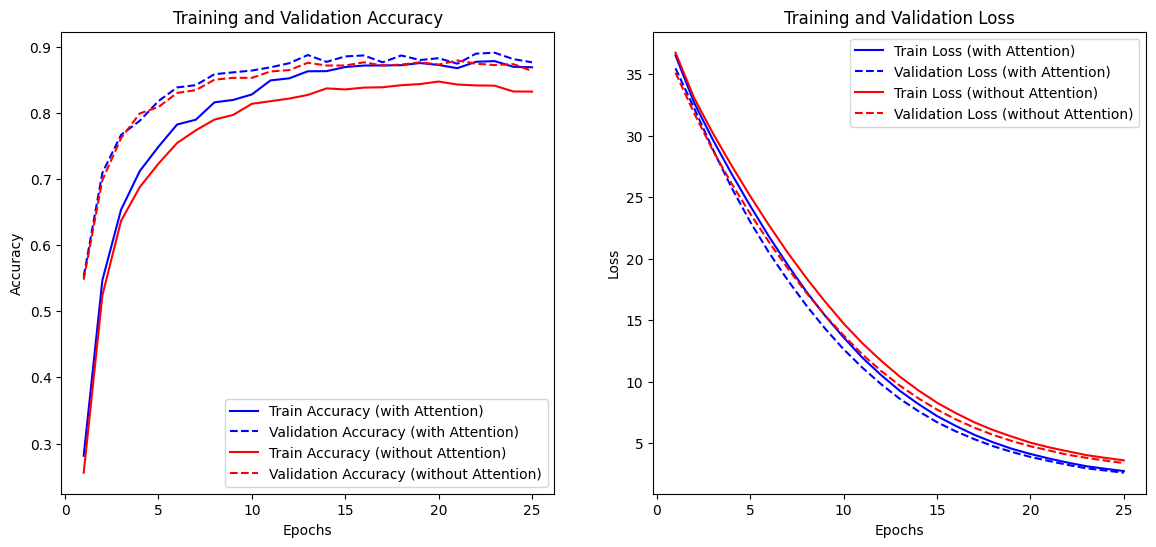

In [14]:
import matplotlib.pyplot as plt

def plot_history(history_with_attention, history_without_attention):
    # Extract the relevant data from the histories
    acc_with_attention = history_with_attention.history['accuracy']
    val_acc_with_attention = history_with_attention.history['val_accuracy']
    loss_with_attention = history_with_attention.history['loss']
    val_loss_with_attention = history_with_attention.history['val_loss']
    
    acc_without_attention = history_without_attention.history['accuracy']
    val_acc_without_attention = history_without_attention.history['val_accuracy']
    loss_without_attention = history_without_attention.history['loss']
    val_loss_without_attention = history_without_attention.history['val_loss']
    
    epochs = range(1, len(acc_with_attention) + 1)

    # Plot training and validation accuracy
    plt.figure(figsize=(14, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc_with_attention, 'b', label='Train Accuracy (with Attention)')
    plt.plot(epochs, val_acc_with_attention, 'b--', label='Validation Accuracy (with Attention)')
    plt.plot(epochs, acc_without_attention, 'r', label='Train Accuracy (without Attention)')
    plt.plot(epochs, val_acc_without_attention, 'r--', label='Validation Accuracy (without Attention)')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss_with_attention, 'b', label='Train Loss (with Attention)')
    plt.plot(epochs, val_loss_with_attention, 'b--', label='Validation Loss (with Attention)')
    plt.plot(epochs, loss_without_attention, 'r', label='Train Loss (without Attention)')
    plt.plot(epochs, val_loss_without_attention, 'r--', label='Validation Loss (without Attention)')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Assuming history_with_attention and history_without_attention contain the history objects
plot_history(history_attention, history)

### Accuracy & Loss

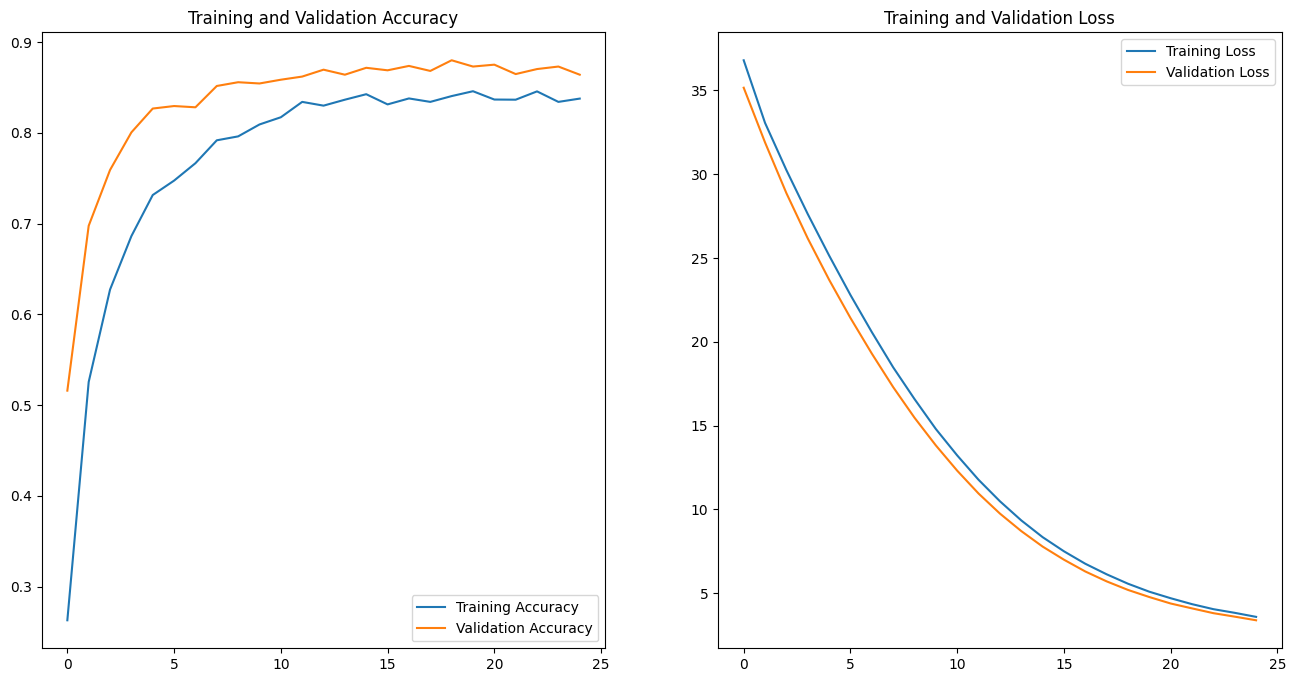

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predictions

In [22]:
img = tf.keras.utils.load_img(
    "/Users/leonardo/Library/CloudStorage/GoogleDrive-leonardofonseca.r@gmail.com/My Drive/04_projects/CryptoVision/Data/training_v2/test/Blenniidae_Cirripectes_variolosus/fish_photo_4797.jpeg",
    target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(" ")
print(
    "Image Specie: {} with a {:.2f}% confidence - {score:.2f} Score."
    .format(class_names[np.argmax(score)], 100 * np.max(predictions[0]), score=max(score) * 100)
)

# Get the top 5 predictions and their confidence scores
top_5_indices = np.argsort(predictions[0])[-5:][::-1]
top_5_confidences = predictions[0][top_5_indices]
top_5_classes = [class_names[i] for i in top_5_indices]

print(" ")
# Print the top 5 predictions and their confidence scores
print("Top 5 predictions with confidence:")
for i, (cls, confidence) in enumerate(zip(top_5_classes, top_5_confidences)):
    print(f"\t {i + 1}. {cls} with a confidence of {100 * confidence:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
 
Image Specie: Blenniidae_Cirripectes_variolosus with a 98.22% confidence - 4.55 Score.
 
Top 5 predictions with confidence:
	 1. Blenniidae_Cirripectes_variolosus with a confidence of 98.22%
	 2. Gobiidae_Priolepis_semidoliatus with a confidence of 0.47%
	 3. Pseudochromidae_Cypho_purpurascens with a confidence of 0.38%
	 4. Blenniidae_Ecsenius_pulcher with a confidence of 0.18%
	 5. Cirrhitidae_Paracirrhites_arcatus with a confidence of 0.11%


## Fine-Tuning

In [13]:
import pickle

model.save("model.keras")

#with open('history.pkl', 'wb') as file:
#    pickle.dump(history.history, file)

In [14]:
ft_model = tf.keras.models.load_model('model.keras')
ft_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 1280)           │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     1,311,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 57)             │        58,425 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,038,013 (38.29 MB)

 Trainable params: 1,372,217 (5.23 MB)

 Non-trainable params: 5,921,360 (22.59 MB)

 Optimizer params: 2,744,436 (10.47 MB)

In [22]:
ft_model.layers[2].trainable = False

# Unfreeze the layers from `unfreeze_from`
for layer in ft_model.layers[2].layers[:100]:
    layer.trainable = True
    
ft_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 1280)           │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     1,311,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 57)             │        58,425 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,579,093 (40.36 MB)

 Trainable params: 2,075,273 (7.92 MB)

 Non-trainable params: 5,218,304 (19.91 MB)

 Optimizer params: 3,285,516 (12.53 MB)

In [23]:
fine_tune_epochs = 10
total_epochs = epochs + fine_tune_epochs

# Compile
ft_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=['accuracy','AUC', 'Precision', 'Recall'],
)

history_fine = ft_model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=total_epochs,
    initial_epoch=len(history.epoch),
    callbacks=[
        early_stop,
        reduce_lr,
    ]

)

Epoch 11/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - AUC: 0.9918 - Precision: 0.8865 - Recall: 0.7360 - accuracy: 0.8041 - loss: 4.0264 - val_AUC: 0.9847 - val_Precision: 0.8794 - val_Recall: 0.7251 - val_accuracy: 0.7866 - val_loss: 3.9658 - learning_rate: 1.0000e-04
Epoch 12/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 86s 939ms/step - AUC: 0.9948 - Precision: 0.9112 - Recall: 0.7870 - accuracy: 0.8495 - loss: 3.6732 - val_AUC: 0.9865 - val_Precision: 0.8954 - val_Recall: 0.7507 - val_accuracy: 0.8066 - val_loss: 3.6772 - learning_rate: 1.0000e-04
Epoch 13/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - AUC: 0.9953 - Precision: 0.9173 - Recall: 0.7982 - accuracy: 0.8502 - loss: 3.4481 - val_AUC: 0.9869 - val_Precision: 0.8943 - val_Recall: 0.7424 - val_accuracy: 0.8011 - val_loss: 3.5354 - learning_rate: 1.0000e-04
Epoch 14/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 87s 954ms/step - AUC: 0.9949 - Precision: 0.9109 - Recall: 0.8043 - accuracy: 0.8582 - loss: 3.2548 - val_AUC: 0.9870 - val_Precision: 0.9019 - val_Re

In [24]:
# First Training
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# Fine-tunning Training
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

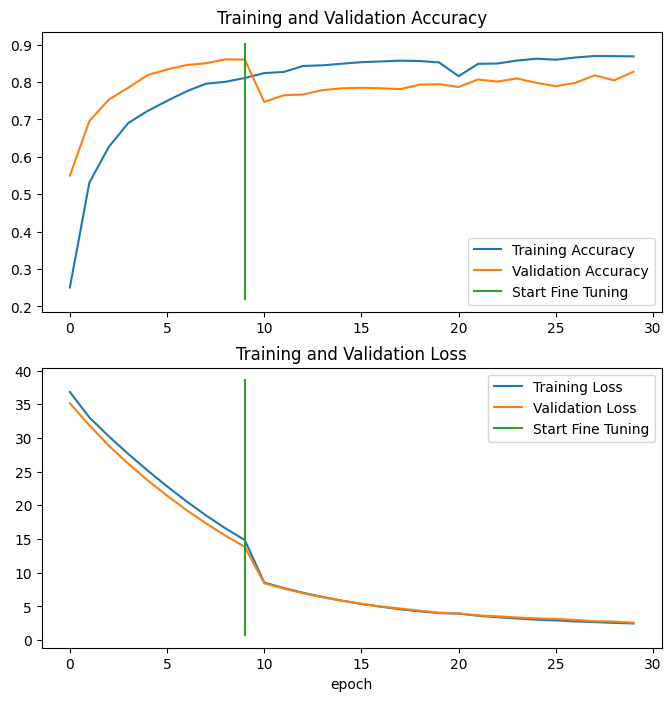

In [25]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
#plt.ylim([0.8, 1])
plt.plot([epochs-1,epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
#plt.ylim([0, 1.0])
plt.plot([epochs-1,epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()